In [ ]:
# Copyright © 2025 UChicago Argonne, LLC All right reserved
# Full license accessible at https://github.com/AdvancedPhotonSource/DONUT/blob/main/LICENSE

import os
import torch
import numpy as np
import pandas as pd
from math import *
import time
from scipy import ndimage
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import cmcrameri.cm as cmc

%matplotlib inline
plt.style.use('/home/beams/B313762/stylesheet.mplstyle')

In [3]:
df = pd.read_csv('./training_losses.csv')
df.head()

,Step,treasured-sky-346 - sim. loss,treasured-sky-346 - sim. loss__MIN,treasured-sky-346 - sim. loss__MAX,northern-elevator-345 - sim. loss,northern-elevator-345 - sim. loss__MIN,northern-elevator-345 - sim. loss__MAX,decent-resonance-296 - sim. loss,decent-resonance-296 - sim. loss__MIN,decent-resonance-296 - sim. loss__MAX,curious-tree-293 - sim. loss,curious-tree-293 - sim. loss__MIN,curious-tree-293 - sim. loss__MAX,bright-planet-276 - sim. loss,bright-planet-276 - sim. loss__MIN,bright-planet-276 - sim. loss__MAX
0,2,1.399314,1.399314,1.399314,1.360613,1.360613,1.360613,1.036501,1.036501,1.036501,0.531316,0.531316,0.531316,1.411950,1.411950,1.411950
1,6,1.370642,1.370642,1.370642,1.350023,1.350023,1.350023,0.754353,0.754353,0.754353,0.290109,0.290109,0.290109,NaN,NaN,NaN
2,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.379683,1.379683,1.379683
3,10,1.367643,1.367643,1.367643,1.348167,1.348167,1.348167,0.714930,0.714930,0.714930,0.259073,0.259073,0.259073,NaN,NaN,NaN
4,14,1.366156,1.366156,1.366156,1.347233,1.347233,1.347233,0.707259,0.707259,0.707259,0.243835,0.243835,0.243835,1.374199,1.374199,1.374199


In [4]:
sim_noisy = df['treasured-sky-346 - sim. loss'].to_numpy()
sim_noisy = sim_noisy[~np.isnan(sim_noisy)]
print('Epochs trained on noisy simulated data: ', sim_noisy.shape[0])
exp_only = df['decent-resonance-296 - sim. loss'].to_numpy()
exp_only = exp_only[~np.isnan(exp_only)]
print('Epochs trained on experimental data: ', exp_only.shape[0])
clean_sim_exp = df['curious-tree-293 - sim. loss'].to_numpy()
clean_sim_exp = clean_sim_exp[~np.isnan(clean_sim_exp)]
print('Epochs trained on clean simulated + experimental data: ', clean_sim_exp.shape[0])
noisy_sim_exp = df['northern-elevator-345 - sim. loss'].to_numpy()
noisy_sim_exp = noisy_sim_exp[~np.isnan(noisy_sim_exp)]
print('Epochs trained on noisy simulated + experimental data: ', noisy_sim_exp.shape[0])
mc_dropout = df['bright-planet-276 - sim. loss'].to_numpy()
mc_dropout = mc_dropout[~np.isnan(mc_dropout)]
print('Epochs trained for MC dropout model: ', mc_dropout.shape[0])

Epochs trained on noisy simulated data:  30
Epochs trained on experimental data:  18
Epochs trained on clean simulated + experimental data:  30
Epochs trained on noisy simulated + experimental data:  28
Epochs trained for MC dropout model:  30


Text(0.5, 1.0, 'MC Dropout (rate = 0.1)')

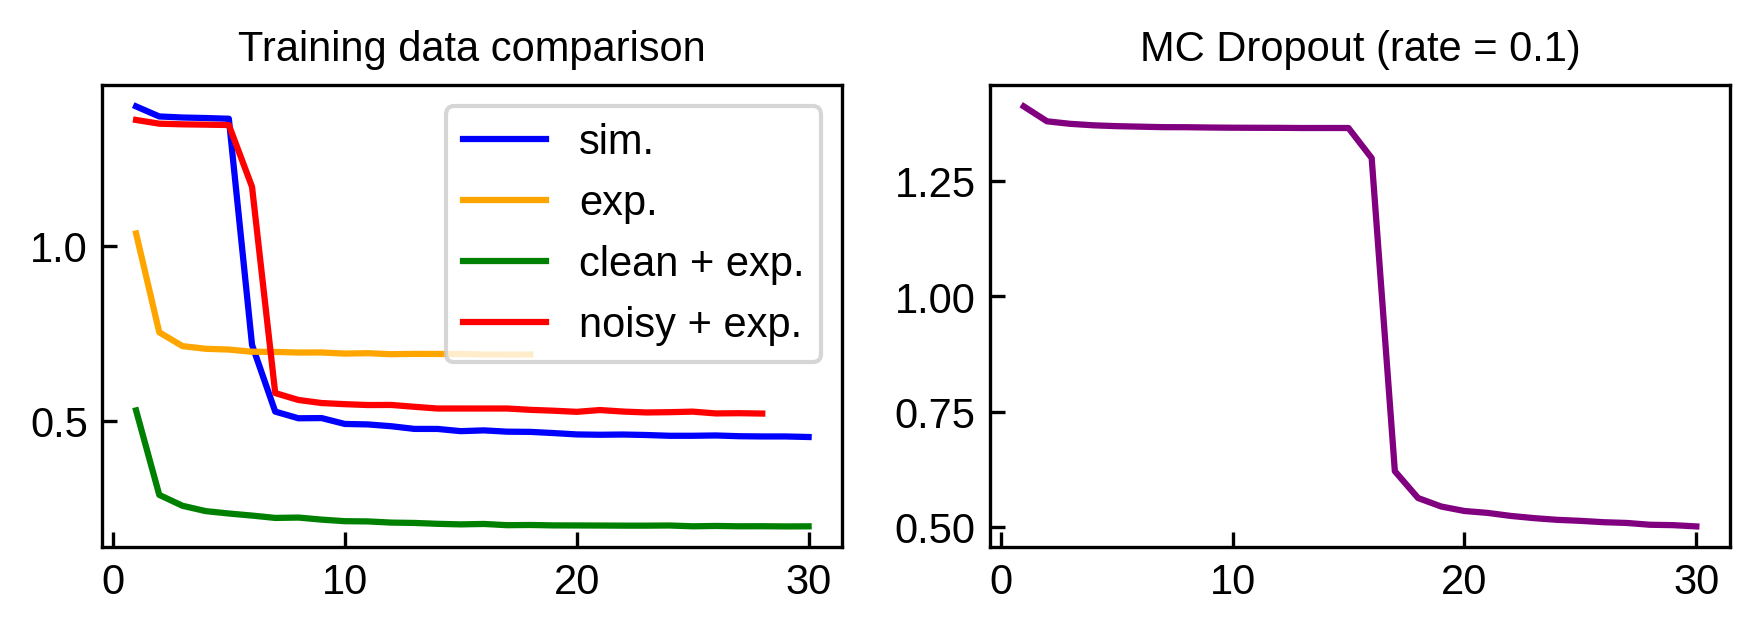

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 2), ncols=2)
ax[0].plot(np.linspace(1, 30, 30), sim_noisy, color='blue', label='sim.')
ax[0].plot(np.linspace(1, 18, 18), exp_only, color='orange', label='exp.')
ax[0].plot(np.linspace(1, 30, 30), clean_sim_exp, color='green', label='clean + exp.')
ax[0].plot(np.linspace(1, 28, 28), noisy_sim_exp, color='red', label='noisy + exp.')
ax[0].tick_params(direction='in')
ax[0].set_title('Training data comparison')
ax[0].legend()

ax[1].plot(np.linspace(1, 30, 30), mc_dropout, color='purple')
ax[1].tick_params(direction='in')
ax[1].set_title('MC Dropout (rate = 0.1)')

#f.savefig('figs4.svg', dpi=300, bbox_inches='tight', transparent=True)

## Load data + pre-processing

In [6]:
data_folder = '/data/aileen/DONUT_data'

sim_mat = np.load(os.path.join(data_folder, 'sim_SIO_4nm_range.npy')) # With thickness

sim_mat[np.isnan(sim_mat)] = 0
sim_mat /= sim_mat.sum(axis=(4, 5), keepdims=True)

sim_mat = np.reshape(sim_mat,
                     (sim_mat.shape[0]*sim_mat.shape[1]*sim_mat.shape[2]*sim_mat.shape[3], 
                     sim_mat.shape[4], sim_mat.shape[5]))
avg_max = np.mean(sim_mat.max(axis=(1, 2)))

print('Data shape: ', sim_mat.shape)

thickness = np.linspace(97, 137, 11)
strain = np.linspace(-0.005, 0.005, 21)
tilt_lr = np.linspace(-0.05, 0.05, 21)
tilt_ud = np.linspace(-0.1, 0.1, 21)

labels = np.zeros((11, 21, 21, 21, 4))
for p0 in range(labels.shape[0]):
    for p1 in range(labels.shape[1]):
        for p2 in range(labels.shape[2]):
            for p3 in range(labels.shape[3]):
                labels[p0, p1, p2, p3] = np.array([thickness[p0], strain[p1], tilt_lr[p2], tilt_ud[p3]])
labels = np.reshape(labels, (labels.shape[0]*labels.shape[1]*labels.shape[2]*labels.shape[3], 
                             labels.shape[4]))

labels = np.float32(np.around(labels, 5))

print('Labels shape: ', labels.shape)

# Normalize data from 0 to average experimental single shot maximum value
sim_mat_norm = np.zeros(sim_mat.shape)
for i in range(sim_mat_norm.shape[0]):
    sim_mat_norm[i] = (sim_mat[i] / avg_max) * 6
print('Normalized min. and max.: ', np.min(sim_mat_norm), np.max(sim_mat_norm))

# Add Poisson noise 
rng = np.random.default_rng()
for i in range(sim_mat_norm.shape[0]):
    sim_mat_norm[i] = rng.poisson(sim_mat_norm[i])

sim_mat_norm = sim_mat_norm.astype('float32')
print('Data type: ', sim_mat_norm.dtype)

Data shape:  (101871, 64, 64)
Labels shape:  (101871, 4)
Normalized min. and max.:  0.0 8.205474814919892
Data type:  float32


In [15]:
print('Loading raw experimental data')
data = np.load(os.path.join(data_folder, 'dataSIO.npy')).astype(np.float32)

Loading raw experimental data


## Check loss landscape

In [8]:
def get_diff_idx(label_arr, label):
    """Takes a label (array) with thickness in the 0th position, strain in the 1st position, tilt_lr in the 2nd 
    position, and tilt_ud in the 3rd position, and returns the index of label_arr at which the label is found."""
    idx_t = np.argwhere(np.around(label_arr[:, 0], 1) == np.around(label[0], 1))
    idx_s = np.argwhere(np.around(label_arr[:, 1], 4) == np.around(label[1], 4))
    idx_lr = np.argwhere(np.around(label_arr[:, 2], 3) == np.around(label[2], 3))
    idx_ud = np.argwhere(np.around(label_arr[:, 3], 3) == np.around(label[3], 3))
    return np.intersect1d(idx_ud, np.intersect1d(idx_lr, np.intersect1d(idx_s, idx_t)))[0]

In [14]:
thickness_arr = np.zeros((11, 64, 64), dtype='float32')
for i in range(thickness_arr.shape[0]):
    position = get_diff_idx(labels, [thickness[i], 0, 0, 0])
    thickness_arr[i] = sim_mat_norm[position]

strain_arr = np.zeros((21, 64, 64), dtype='float32')
for i in range(strain_arr.shape[0]):
    position = get_diff_idx(labels, [117, strain[i], 0, 0])
    strain_arr[i] = sim_mat_norm[position]

tilt_lr_arr = np.zeros((21, 64, 64), dtype='float32')
for i in range(tilt_lr_arr.shape[0]):
    position = get_diff_idx(labels, [117, 0, tilt_lr[i], 0])
    tilt_lr_arr[i] = sim_mat_norm[position]

tilt_ud_arr = np.zeros((21, 64, 64), dtype='float32')
for i in range(tilt_ud_arr.shape[0]):
    position = get_diff_idx(labels, [117, 0, 0, tilt_ud[i]])
    tilt_ud_arr[i] = sim_mat_norm[position]

In [10]:
class DiffDataset(Dataset):
    """Makes PyTorch Dataset object for diffraction data (images)."""
    
    def __init__(self, data, params=None, transform=None):
        self.data = data
        if isinstance(params, np.ndarray):
            self.params = params
        else:
            self.params = None
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = self.data[idx]
        if isinstance(self.params, np.ndarray):
            lattice = self.params[idx]
            sample={'image': image, 'lattice': lattice}
        else:
            sample = {'image': image, 'lattice': None}
            
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert numpy arrays to Tensors"""
    def __call__(self, sample):
        image = sample['image']
        if isinstance(sample['lattice'], np.ndarray):
            lattice = sample['lattice']
            return {'image': torch.unsqueeze(torch.from_numpy(image), 0), 'lattice': torch.from_numpy(lattice)}
        return {'image': torch.unsqueeze(torch.from_numpy(image), 0), 'lattice': 0}

In [16]:
thickness_dataset = DiffDataset(data=thickness_arr, params=thickness, transform=ToTensor())
strain_dataset = DiffDataset(data=strain_arr, params=strain, transform=ToTensor())
tilt_lr_dataset = DiffDataset(data=tilt_lr_arr, params=tilt_lr, transform=ToTensor())
tilt_ud_dataset = DiffDataset(data=tilt_ud_arr, params=tilt_ud, transform=ToTensor())

exp_dataset = DiffDataset(data=data[12385][np.newaxis, :, :], params=None, transform=ToTensor())
exp_dataset[0]['image'].shape

torch.Size([1, 64, 64])

In [17]:
criterion = nn.SmoothL1Loss()

thickness_loss = []
for i, data in enumerate(thickness_dataset):
    loss = criterion(data['image'], thickness_dataset[5]['image'])
    thickness_loss.append(loss)

strain_loss = []
for i, data in enumerate(strain_dataset):
    loss = criterion(data['image'], strain_dataset[10]['image'])
    strain_loss.append(loss)

tilt_lr_loss = []
for i, data in enumerate(tilt_lr_dataset):
    loss = criterion(data['image'], tilt_lr_dataset[10]['image'])
    tilt_lr_loss.append(loss)
    
tilt_ud_loss = []
for i, data in enumerate(tilt_ud_dataset):
    loss = criterion(data['image'], tilt_ud_dataset[10]['image'])
    tilt_ud_loss.append(loss)

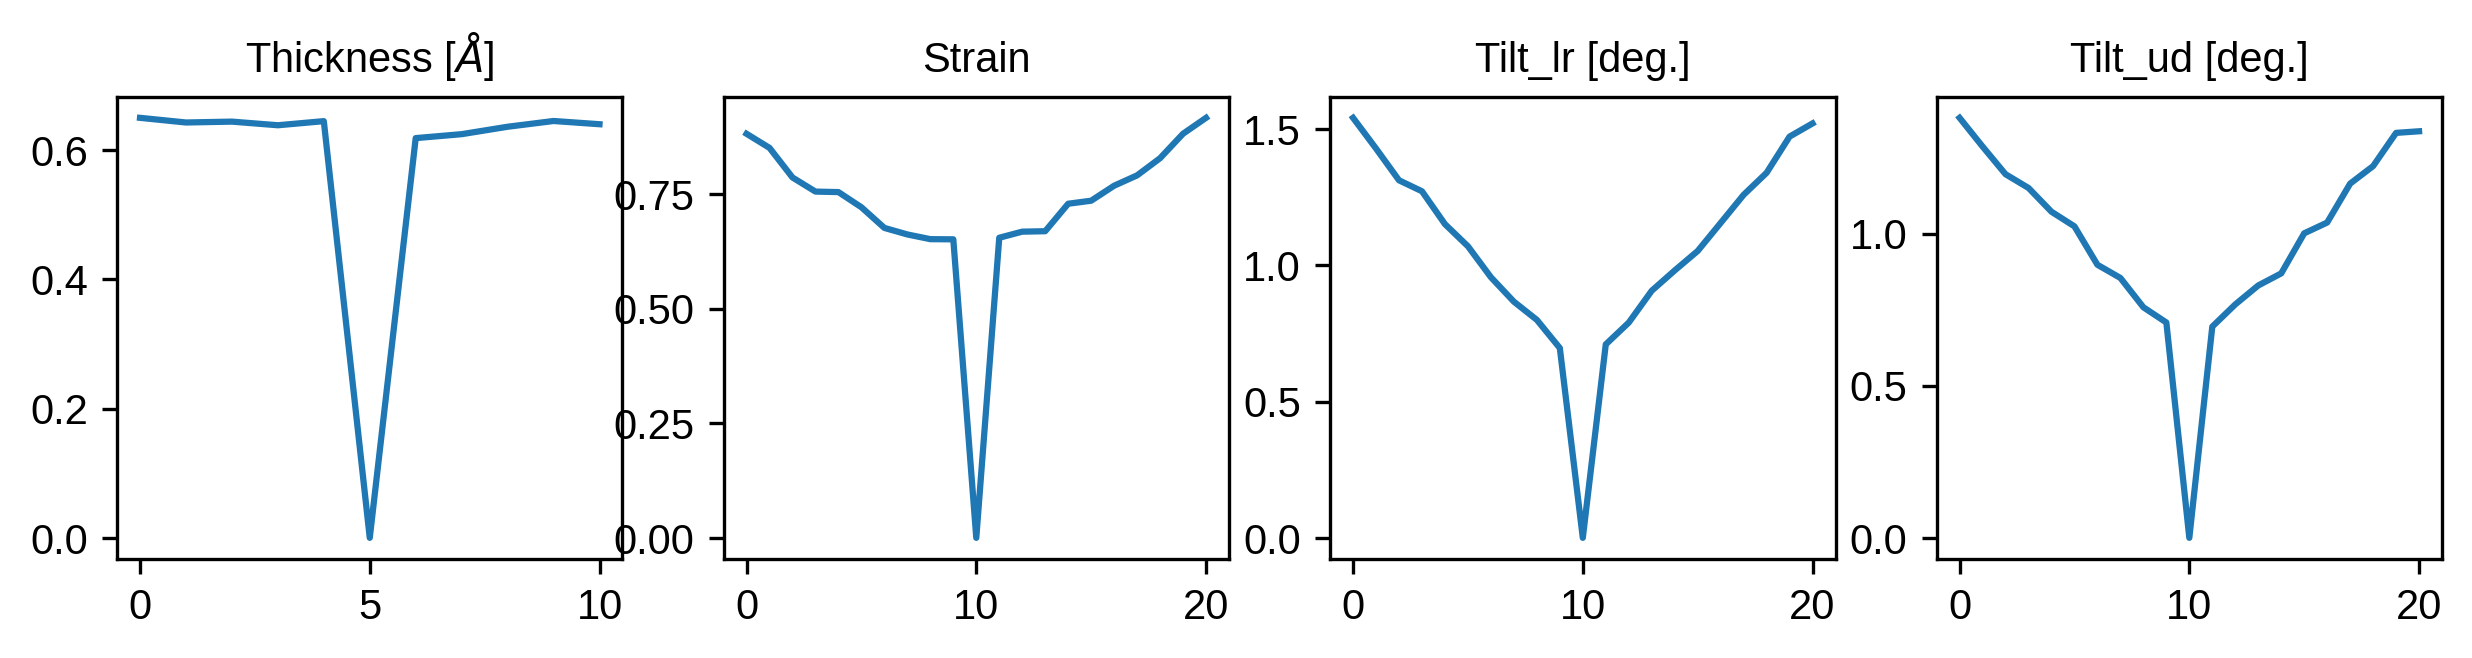

In [19]:
# import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(10, 2), ncols=4)

ax[0].plot(thickness_loss)
ax[0].set_title('Thickness [$\AA$]')
ax[1].plot(strain_loss)
ax[1].set_title('Strain')
ax[2].plot(tilt_lr_loss)
ax[2].set_title('Tilt_lr [deg.]')
ax[3].plot(tilt_ud_loss)
ax[3].set_title('Tilt_ud [deg.]')

# f.savefig('figs9a.svg', dpi=300, bbox_inches='tight', transparent=True)

In [20]:
# Loss between each parameter and random experimental datapoint

criterion = nn.SmoothL1Loss()

thickness_loss = []
for i, data in enumerate(thickness_dataset):
    loss = criterion(data['image'], exp_dataset[0]['image'])
    thickness_loss.append(loss)

strain_loss = []
for i, data in enumerate(strain_dataset):
    loss = criterion(data['image'], exp_dataset[0]['image'])
    strain_loss.append(loss)

tilt_lr_loss = []
for i, data in enumerate(tilt_lr_dataset):
    loss = criterion(data['image'], exp_dataset[0]['image'])
    tilt_lr_loss.append(loss)
    
tilt_ud_loss = []
for i, data in enumerate(tilt_ud_dataset):
    loss = criterion(data['image'], exp_dataset[0]['image'])
    tilt_ud_loss.append(loss)

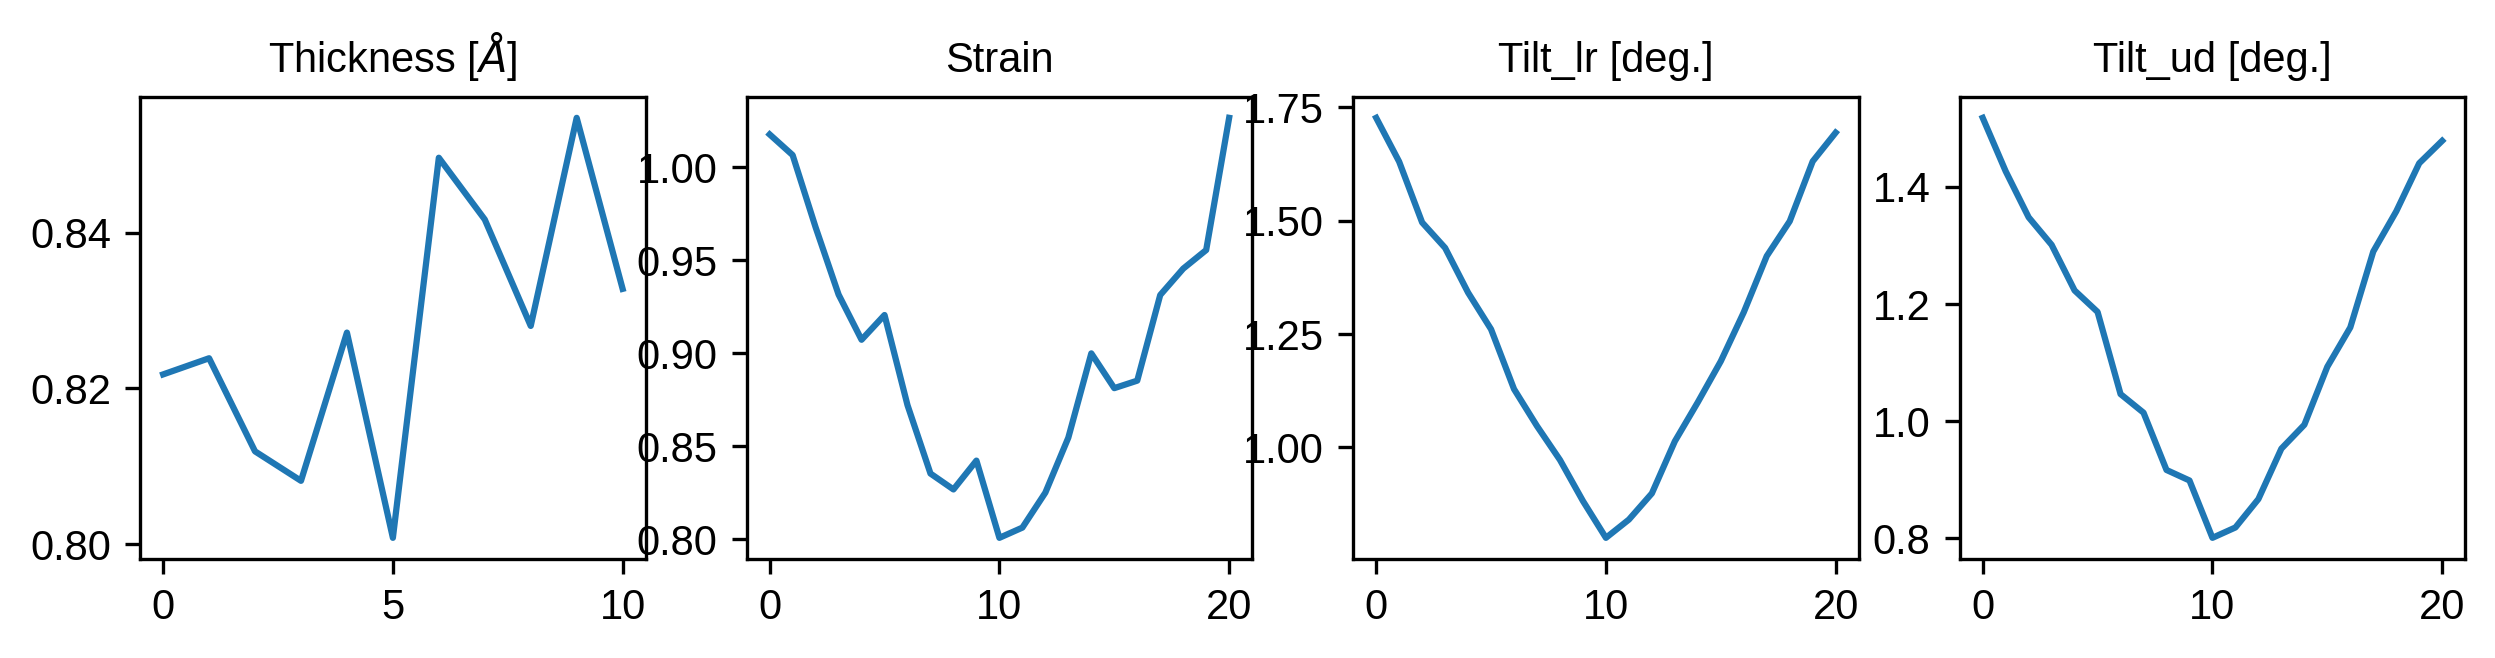

In [22]:
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(10, 2), ncols=4)

ax[0].plot(thickness_loss)
ax[0].set_title('Thickness [$\AA$]')
ax[1].plot(strain_loss)
ax[1].set_title('Strain')
ax[2].plot(tilt_lr_loss)
ax[2].set_title('Tilt_lr [deg.]')
ax[3].plot(tilt_ud_loss)
ax[3].set_title('Tilt_ud [deg.]')

#f.savefig('figs9b.svg', dpi=300, bbox_inches='tight', transparent=True)

In [23]:
full_dataset = DiffDataset(data=sim_mat_norm, params=labels, transform=ToTensor())
position = get_diff_idx(labels, [117, 0, 0, 0])
position

50935

In [24]:
full_loss = []
for i, data in enumerate(full_dataset):
    loss = criterion(data['image'], full_dataset[position]['image'])
    full_loss.append(loss)
full_loss = np.asarray(full_loss)

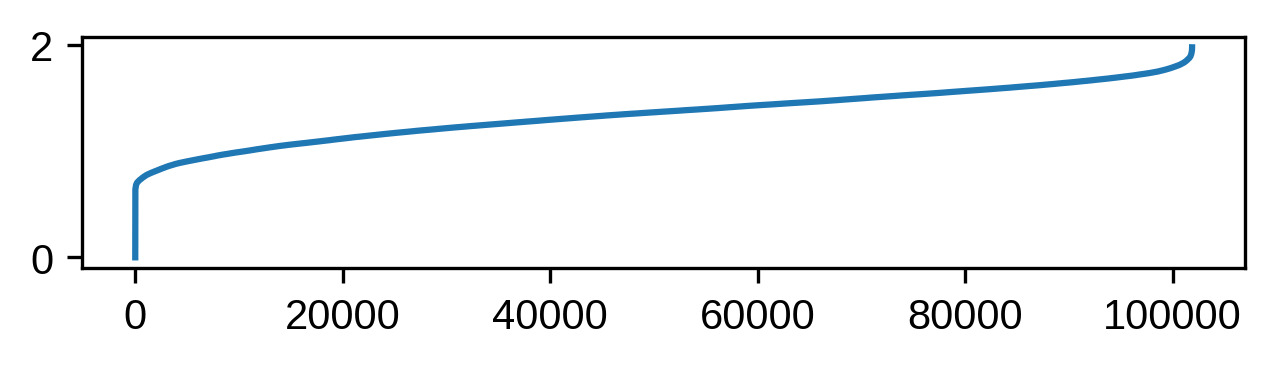

In [33]:
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(5, 1))
ax.plot(sorted(full_loss))

#f.savefig('figs9c.svg', dpi=300, bbox_inches='tight', transparent=True)

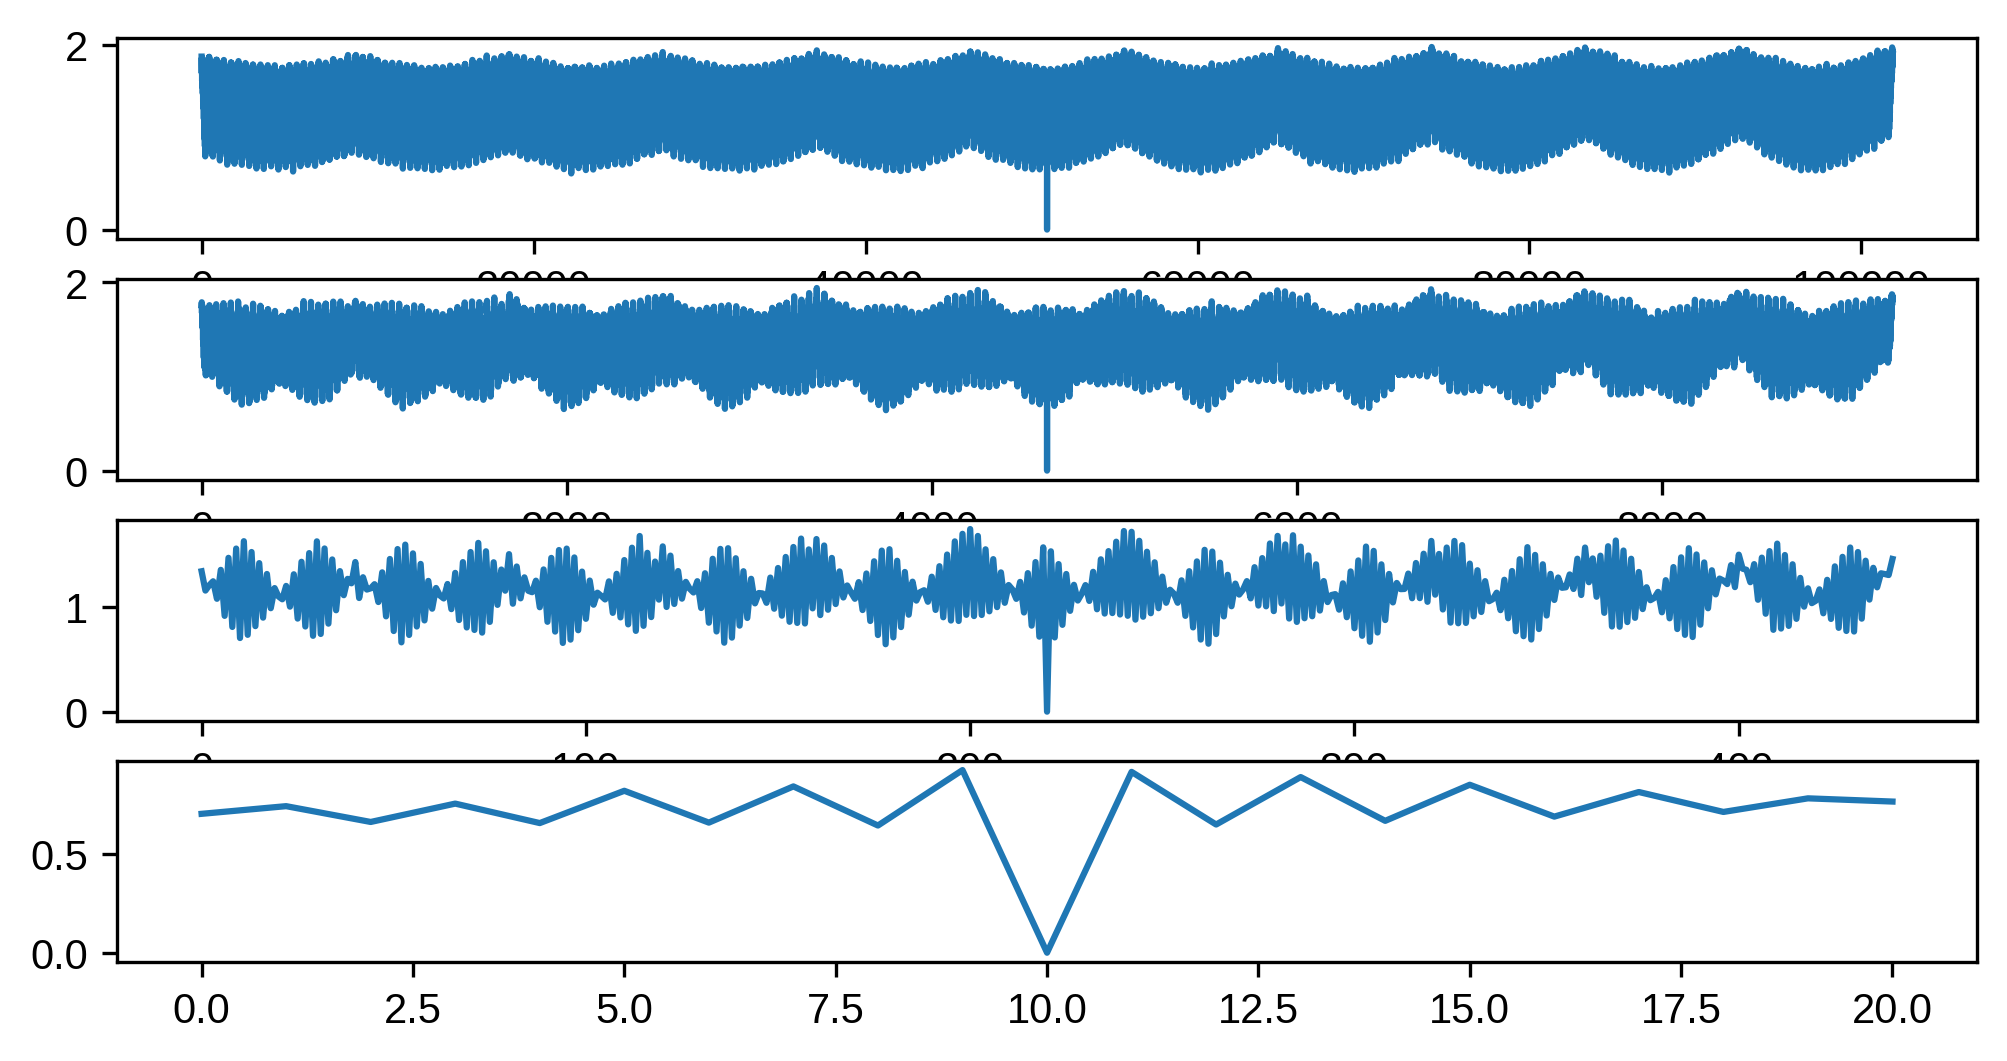

In [26]:
f, ax = plt.subplots(figsize=(8, 4), nrows=4)
ax[0].plot(full_loss)
ax[1].plot(full_loss[5::11])
ax[2].plot(full_loss[5::11][10::21])
ax[3].plot(full_loss[5::11][10::21][10::21])

In [27]:
full_loss_exp = []
for i, data in enumerate(full_dataset):
    loss = criterion(data['image'], exp_dataset[0]['image'])
    full_loss_exp.append(loss)
full_loss_exp = np.asarray(full_loss_exp)

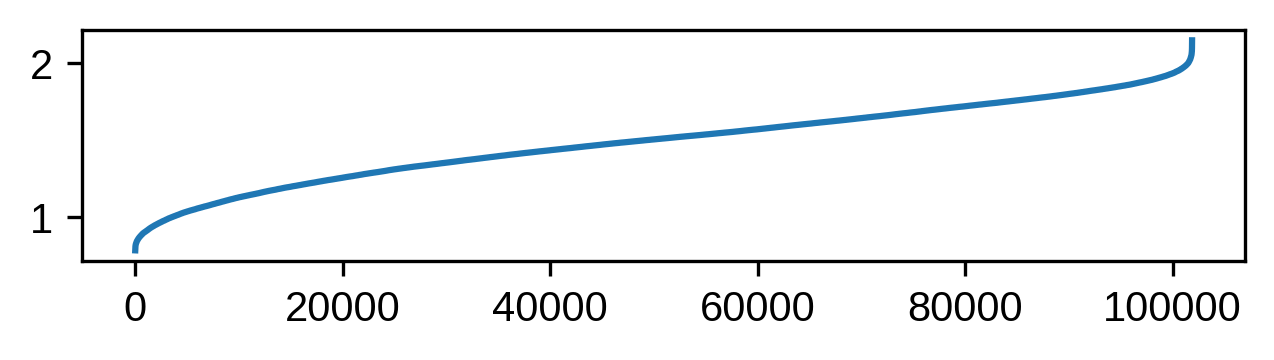

In [35]:
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
f, ax = plt.subplots(figsize=(5, 1))
ax.plot(sorted(full_loss_exp))
#f.savefig('figs9d.svg', dpi=300, bbox_inches='tight', transparent=True)

In [29]:
xt, yt, zt = np.meshgrid(strain, tilt_lr, tilt_ud)
xs, ys, zs = np.meshgrid(thickness, tilt_lr, tilt_ud)
x_lr, y_lr, z_lr = np.meshgrid(thickness, strain, tilt_ud)
x_ud, y_ud, z_ud = np.meshgrid(thickness, strain, tilt_lr)

In [30]:
loss_reshaped = np.reshape(full_loss, (11, 21, 21, 21))

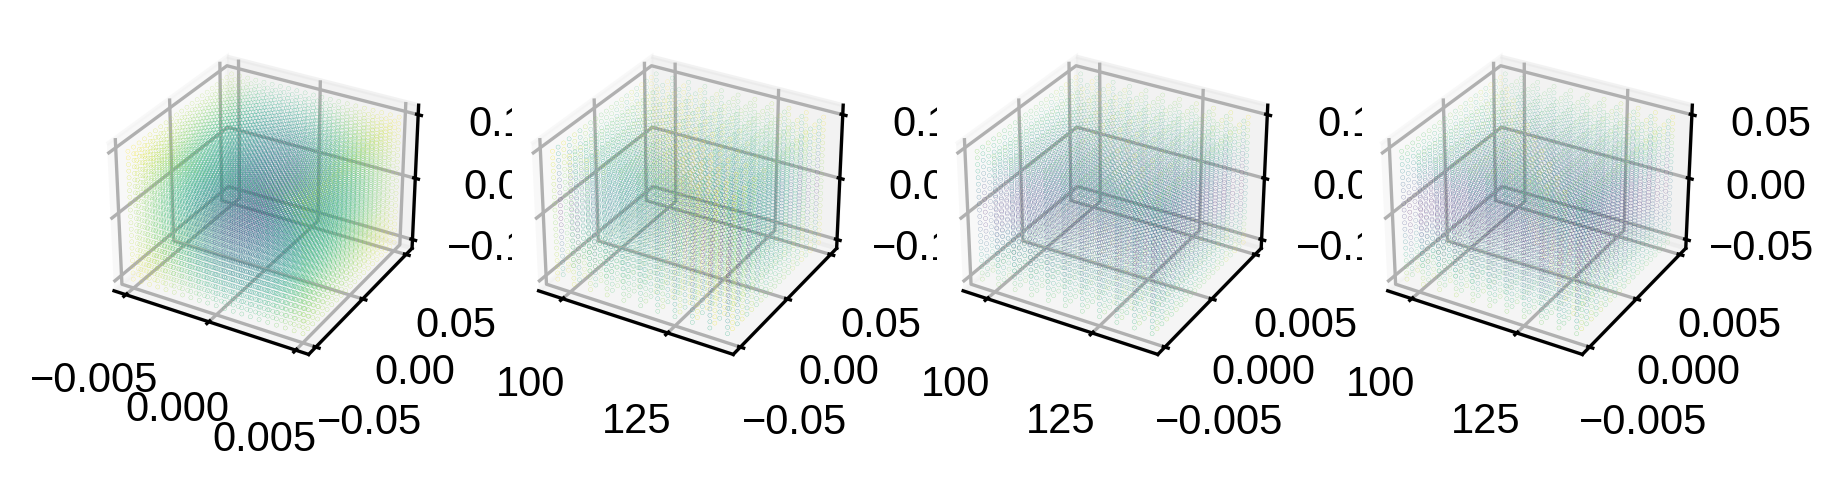

In [31]:
f, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7, 1.5), ncols=4)

ax[0].scatter(xs=xt.flatten(), ys=yt.flatten(), zs=zt.flatten(), c=loss_reshaped.sum(axis=0).flatten(), s=0.005)
ax[1].scatter(xs=xs.flatten(), ys=ys.flatten(), zs=zs.flatten(), c=loss_reshaped.sum(axis=1).flatten(), s=0.005)
ax[2].scatter(xs=x_lr.flatten(), ys=y_lr.flatten(), zs=z_lr.flatten(), c=loss_reshaped.sum(axis=2).flatten(), 
              s=0.005)
ax[3].scatter(xs=x_ud.flatten(), ys=y_ud.flatten(), zs=z_ud.flatten(), c=loss_reshaped.sum(axis=3).flatten(), 
              s=0.005)